In [153]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from enum import Enum
from sklearn.metrics.pairwise import rbf_kernel
import sklearn.neighbors as neighbors

import matplotlib
matplotlib.rcParams['figure.figsize'] = [20, 15]


sigma_sq = .01
n_clusters = 2
n_samples = 100
np.random.seed(1234)

dataset_collection = []
dataset_collection.append(datasets.make_circles(n_samples, factor = 0.5, noise = 0.05))
dataset_collection.append(datasets.make_moons(n_samples, noise = 0.05))
dataset_collection.append(datasets.make_blobs(n_samples, centers = 3, n_features = 2))
dataset_collection.append(datasets.make_blobs(n_samples, centers = 4, n_features = 2, cluster_std=[0.5, 1, 1, 2]))


titles = ["Circles", "Moons", "Blobs", "Varied variance"]

class Algorithm(Enum):
        KMEANS = 1
        SPECTRAL = 2

class LaplaciansType(Enum):
        UNNORM = 1
        NORM_SYM = 2
        NORM_RW = 3
        
class GraphType(Enum):
        FULL = 1
        KNN = 2
        EPSILON = 3

def get_laplacians(W, laplacian_type):
    # Construct diagonal degree matrix
    D = np.zeros(W.shape)
    for i in range(W.shape[0]):
        D[i, i] = np.sum(W[i, :])
        
    L = np.zeros(W.shape)
    I = np.matlib.identity(W.shape[0])
    
    if laplacian_type == LaplaciansType.UNNORM:
        L = D - W
    elif laplacian_type == LaplaciansType.NORM_SYM:
        D_inv_sq = np.sqrt(np.linalg.inv(D))
        L = I - D_inv_sq @ W @ D_inv_sq
    elif laplacian_type == LaplaciansType.NORM_RW:
        D_inv = np.linalg.inv(D)
        L = I - D_inv @ W
    
    return L


def make_graph(data, gtype, parameter):
    if (gtype == GraphType.FULL):
        # gamma = 1 / (2 * sigma^2)
        return rbf_kernel(data, gamma = parameter)
    
    elif (gtype == GraphType.KNN):
        knn = neighbors.kneighbors_graph(data, n_neighbors = parameter).toarray()
        # make knn adjacency matrix symmetric
        knn = 0.5 * (knn + knn.T)
        return knn
    
    elif (gtype == GraphType.EPSILON):
        return neighbors.radius_neighbors_graph(data, radius = parameter).toarray()
    

def spectral_clustering(weighted_graph, cluster_count, laplacian_type):
    W = weighted_graph
    K = cluster_count
        
    # Construct Laplacian Matrix:
    L = get_laplacians(W, laplacian_type)
    
    # Find the K first eigenvectors of L
    eigvals, eigvects = np.linalg.eigh(L)
    first_eigens = [i for i in range(K)]
    
    U = np.zeros((L.shape[0], K))
    U[:, :] = eigvects[:, first_eigens]
    
    if laplacian_type == LaplaciansType.NORM_SYM:
        # normalize new eigenvector-column-matrix
        U = (U.T / np.linalg.norm(U, axis = 1)).T
    
    # Finally, do clustering on reduced space using KMeans:
    km = KMeans(n_clusters = K, n_init = 20)
    km.fit(U)
    y_pred = km.labels_ #1 if x > 0 else 0 for x in T
    return y_pred


def plot_results(datasets, titles, params = None, alg_type = None):
    for i in range(len(datasets)):
        data, labels = datasets[i]
        plt.subplot(4, 4, i + 1)
        plt.title(titles[i])
        plt.scatter(data[:, 0], data[:, 1], c = labels)
    if (alg_type == Algorithm.KMEANS):
        plt.suptitle("KMeans")
    elif (alg_type == Algorithm.SPECTRAL):
        plt.suptitle("Spectral clustering, {}, parameter: {}, {}".format(params['gtype'], params['gparam'], params['ltype']))
    else:
        plt.suptitle("Ground Truth")
    plt.show()
    
def run_algorithm(alg_type, datasets, n_clusters, params = None):
    results = []
    
    if(alg_type == Algorithm.KMEANS):
        for i, (data, labels) in enumerate(datasets):
            alg = KMeans(n_clusters[i])
            alg.fit(data)
            results.append((data, alg.labels_))        
    
    elif (alg_type == Algorithm.SPECTRAL):
        for i, (data, labels) in enumerate(datasets):
            graph = make_graph(data, gtype=params['gtype'], parameter=params['gparam'])
            labels = spectral_clustering(graph, n_clusters[i], params['ltype'])
            results.append((data, labels))
            
    return results
    

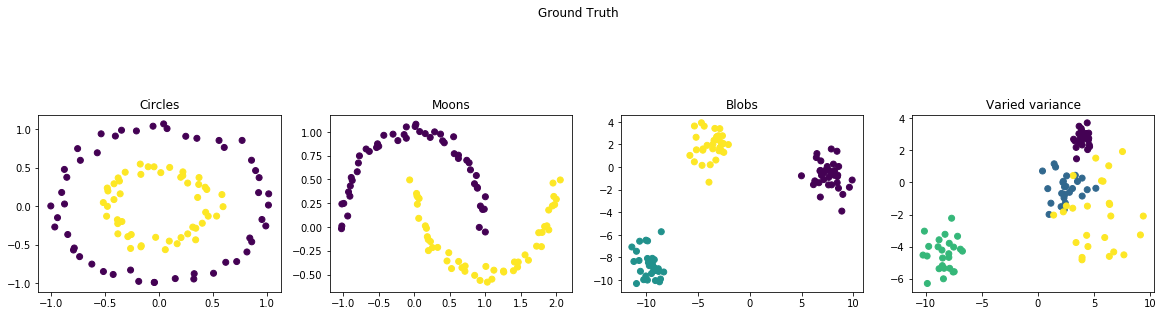

In [146]:
plot_results(dataset_collection, titles)

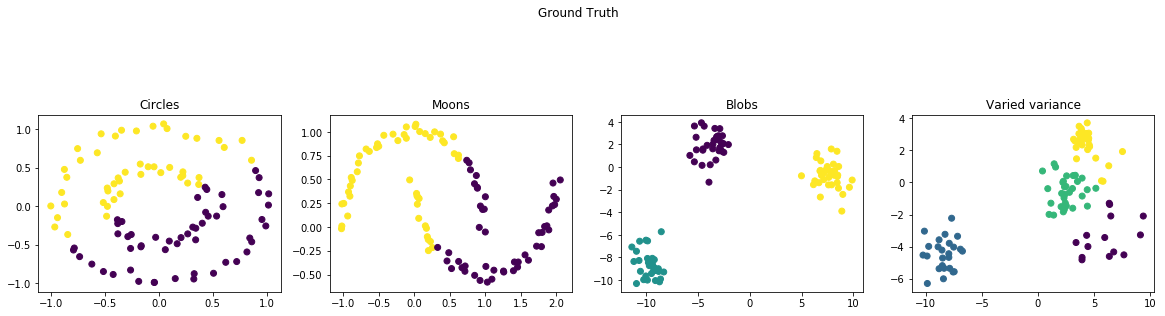

In [147]:
results = run_algorithm(Algorithm.KMEANS, dataset_collection, n_clusters=[2, 2, 3, 4])
plot_results(results, titles, Algorithm.KMEANS)

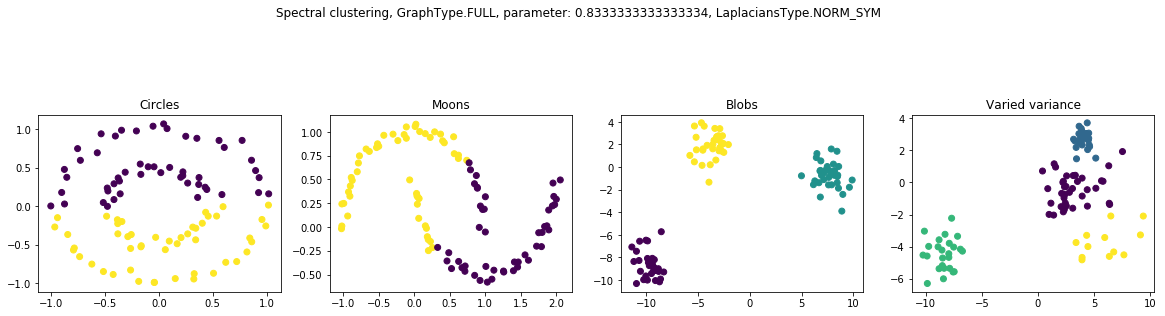

In [150]:
params = {'gtype' : GraphType.FULL, 'ltype' : LaplaciansType.NORM_SYM, 'gparam' : 1 / 1.2}
results = run_algorithm(Algorithm.SPECTRAL, dataset_collection, n_clusters=[2, 2, 3, 4], params=params)
plot_results(results, titles, params, Algorithm.SPECTRAL)

In [71]:
from numpy.linalg import norm
from math import exp

# compute the affinity of samples X1, X2
def affinity_kernel(x1, x2):
    return exp(-(norm(x1 - x2) ** 2) / (2 * sigma_sq))

# construct affinity matrix
A = np.zeros((len(dataset), len(dataset)))
for i in range(len(dataset) - 1):
    for j in range(i + 1, len(dataset)):
        A[i, j] = affinity_kernel(dataset[i], dataset[j])
        A[j, i] = A[i, j]

# print affinity matrix
np.set_printoptions(precision = 2)
print(A)

[[0.00e+00 1.03e-03 1.63e-51 ... 1.34e-19 4.84e-76 1.37e-16]
 [1.03e-03 0.00e+00 1.05e-65 ... 1.30e-13 2.84e-81 4.45e-20]
 [1.63e-51 1.05e-65 0.00e+00 ... 5.25e-43 9.14e-13 6.51e-16]
 ...
 [1.34e-19 1.30e-13 5.25e-43 ... 0.00e+00 5.28e-38 1.72e-08]
 [4.84e-76 2.84e-81 9.14e-13 ... 5.28e-38 0.00e+00 7.95e-23]
 [1.37e-16 4.45e-20 6.51e-16 ... 1.72e-08 7.95e-23 0.00e+00]]
